In [ ]:
!pip install kaggle

In [ ]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [ ]:
import json
token = {'username':'kaiwalyashukla','key':'e068fd8e65fff480811edca67b722572'}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

 99% 1.20G/1.21G [00:30<00:00, 68.4MB/s]
100% 1.21G/1.21G [00:30<00:00, 42.2MB/s]


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os, json, math, librosa

import IPython.display as ipd
import librosa.display

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D

import sklearn.model_selection as sk

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import zipfile

file = zipfile.ZipFile("/content/{/content}/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/gtzan-dataset-music-genre-classification.zip","r")
file.extractall('/tmp')
file.close()

In [ ]:
MUSIC = '/tmp/Data/genres_original'
music_dataset = [] # File locations for each wav file 
genre_target = []  
for root, dirs, files in os.walk(MUSIC):
    for name in files:
        filename = os.path.join(root, name)
        if filename != '/tmp/Data/genres_original/jazz/jazz.00054.wav':
            music_dataset.append(filename)
            genre_target.append(filename.split("/")[4])

In [ ]:
set(genre_target)

{'blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock'}

In [ ]:
audio_path = music_dataset[500]

x , sr = librosa.load(audio_path)

librosa.load(audio_path, sr=None)

ipd.Audio(audio_path)

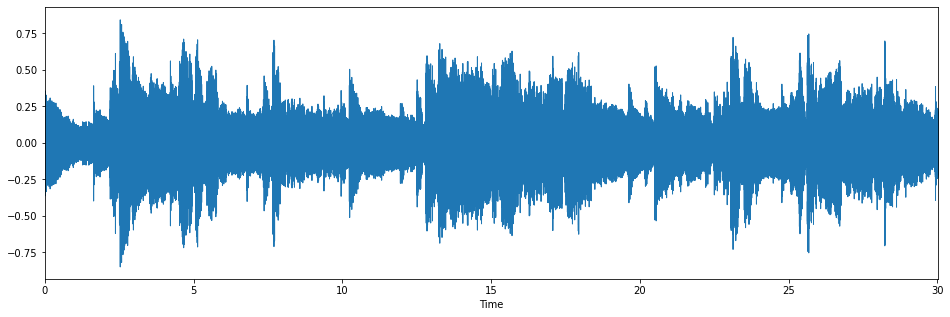

In [ ]:
plt.figure(figsize=(16, 5))
librosa.display.waveplot(x, sr=sr)

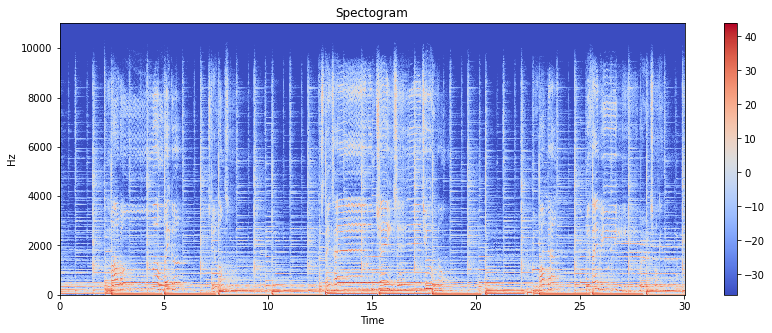

In [ ]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.title('Spectogram')
plt.colorbar()

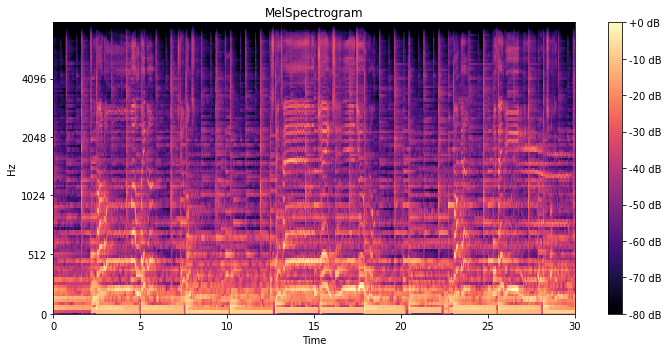

In [ ]:
file_location = audio_path
y, sr = librosa.load(file_location)
melSpec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
melSpec_dB = librosa.power_to_db(melSpec, ref=np.max)
plt.figure(figsize=(10, 5))
librosa.display.specshow(melSpec_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+1.0f dB')
plt.title("MelSpectrogram")
plt.tight_layout()
plt.show()

In [ ]:
DATASET_PATH = '/tmp/Data/genres_original/'
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file

                file_path = os.path.join(dirpath, f)
            
                if file_path != '/tmp/Data/genres_original/jazz/jazz.00054.wav':

                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                
                
                    # process all segments of audio file
                    for d in range(num_segments):

                        # calculate start and finish sample for current segment
                        start = samples_per_segment * d
                        finish = start + samples_per_segment

                        # extract mfcc
                        mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        mfcc = mfcc.T

                        # store only mfcc feature with expected number of vectors
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=6)

Streaming output truncated to the last 5000 lines.
/tmp/Data/genres_original/reggae/reggae.00084.wav, segment:2
/tmp/Data/genres_original/reggae/reggae.00084.wav, segment:3
/tmp/Data/genres_original/reggae/reggae.00084.wav, segment:4
/tmp/Data/genres_original/reggae/reggae.00084.wav, segment:5
/tmp/Data/genres_original/reggae/reggae.00084.wav, segment:6
/tmp/Data/genres_original/reggae/reggae.00060.wav, segment:1
/tmp/Data/genres_original/reggae/reggae.00060.wav, segment:2
/tmp/Data/genres_original/reggae/reggae.00060.wav, segment:3
/tmp/Data/genres_original/reggae/reggae.00060.wav, segment:4
/tmp/Data/genres_original/reggae/reggae.00060.wav, segment:5
/tmp/Data/genres_original/reggae/reggae.00060.wav, segment:6
/tmp/Data/genres_original/reggae/reggae.00090.wav, segment:1
/tmp/Data/genres_original/reggae/reggae.00090.wav, segment:2
/tmp/Data/genres_original/reggae/reggae.00090.wav, segment:3
/tmp/Data/genres_original/reggae/reggae.00090.wav, segment:4
/tmp/Data/genres_original/reggae/r

In [ ]:
DATA_PATH = "/content/data_10.json"


def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    z = np.array(data['mapping'])
    return X, y, z


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    :return z : Mappings for data
    """

    # load data
    X, y, z = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, z


def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))
    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)
    
    # get mappings for target and predicted label
    target = z[y]
    predicted = z[predicted_index]

    print("Target: {}, Predicted label: {}".format(target, predicted))

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(0.25, 0.2)

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-8)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=128, epochs=100,callbacks=[lr_schedule])

Epoch 1/100
29/29 [==============================] - 2s 52ms/step - loss: 2.9843 - accuracy: 0.0890 - val_loss: 3.5423 - val_accuracy: 0.0857 - lr: 1.0000e-08
Epoch 2/100
29/29 [==============================] - 1s 30ms/step - loss: 2.9957 - accuracy: 0.0885 - val_loss: 2.9173 - val_accuracy: 0.0790 - lr: 1.1220e-08
Epoch 3/100
29/29 [==============================] - 1s 30ms/step - loss: 2.9860 - accuracy: 0.0946 - val_loss: 2.7206 - val_accuracy: 0.0701 - lr: 1.2589e-08
Epoch 4/100
29/29 [==============================] - 1s 31ms/step - loss: 2.9735 - accuracy: 0.0985 - val_loss: 2.6569 - val_accuracy: 0.0756 - lr: 1.4125e-08
Epoch 5/100
29/29 [==============================] - 1s 30ms/step - loss: 2.9896 - accuracy: 0.0862 - val_loss: 2.6378 - val_accuracy: 0.0801 - lr: 1.5849e-08
Epoch 6/100
29/29 [==============================] - 1s 31ms/step - loss: 2.9938 - accuracy: 0.0974 - val_loss: 2.6357 - val_accuracy: 0.0756 - lr: 1.7783e-08
Epoch 7/100
29/29 [===========================

(1e-08, 0.001, 0.0, 5.0)

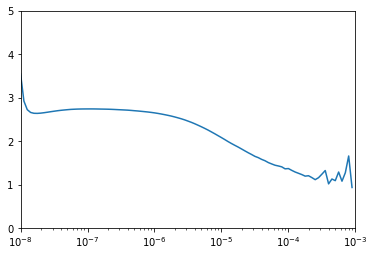

In [ ]:
plt.semilogx(history.history["lr"], history.history["val_loss"])
plt.axis([1e-8, 1e-3, 0, 5])

Epoch 1/200
29/29 [==============================] - 1s 39ms/step - loss: 2.6613 - accuracy: 0.1227 - val_loss: 3.0551 - val_accuracy: 0.1012
Epoch 2/200
29/29 [==============================] - 1s 31ms/step - loss: 2.1955 - accuracy: 0.2156 - val_loss: 2.2554 - val_accuracy: 0.1858
Epoch 3/200
29/29 [==============================] - 1s 32ms/step - loss: 1.9557 - accuracy: 0.3082 - val_loss: 2.0062 - val_accuracy: 0.2592
Epoch 4/200
29/29 [==============================] - 1s 32ms/step - loss: 1.8033 - accuracy: 0.3588 - val_loss: 1.8788 - val_accuracy: 0.3482
Epoch 5/200
29/29 [==============================] - 1s 31ms/step - loss: 1.7154 - accuracy: 0.3725 - val_loss: 1.7769 - val_accuracy: 0.3882
Epoch 6/200
29/29 [==============================] - 1s 31ms/step - loss: 1.6103 - accuracy: 0.4270 - val_loss: 1.7013 - val_accuracy: 0.4138
Epoch 7/200
29/29 [==============================] - 1s 31ms/step - loss: 1.5502 - accuracy: 0.4348 - val_loss: 1.6157 - val_accuracy: 0.4305
Epoch 

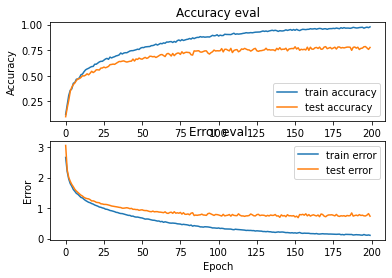

47/47 - 0s - loss: 0.8564 - accuracy: 0.7570

Test accuracy: 0.7570093274116516


In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

optimizer = tf.keras.optimizers.Adam(lr=6e-5)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=128, epochs=200)

plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
for i in range(X_test.shape[0]):
    X_to_predict = X_test[i]
    y_to_predict = y_test[i]

    predict(model, X_to_predict, y_to_predict)

Target: blues, Predicted label: ['blues']
Target: jazz, Predicted label: ['classical']
Target: rock, Predicted label: ['rock']
Target: reggae, Predicted label: ['reggae']
Target: metal, Predicted label: ['metal']
Target: jazz, Predicted label: ['blues']
Target: metal, Predicted label: ['metal']
Target: blues, Predicted label: ['country']
Target: pop, Predicted label: ['pop']
Target: hiphop, Predicted label: ['metal']
Target: pop, Predicted label: ['pop']
Target: rock, Predicted label: ['blues']
Target: country, Predicted label: ['country']
Target: hiphop, Predicted label: ['disco']
Target: classical, Predicted label: ['classical']
Target: country, Predicted label: ['country']
Target: jazz, Predicted label: ['jazz']
Target: reggae, Predicted label: ['reggae']
Target: jazz, Predicted label: ['blues']
Target: country, Predicted label: ['country']
Target: disco, Predicted label: ['disco']
Target: country, Predicted label: ['country']
Target: metal, Predicted label: ['metal']
Target: reggae

In [ ]:
model.save("modelnew2.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
model_json = model.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
from keras.models import load_model 
keras_file ="modelnew2.h5" 
keras.models.save_model(model,keras_file)
from tensorflow import lite 
coverter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(keras_file)

Using TensorFlow backend.


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('model1.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_path="model1.tflite")
interpreter.allocate_tensors()

print(interpreter.get_input_details()[0]['shape'])  
print(interpreter.get_input_details()[0]['dtype']) 

print(interpreter.get_output_details()[0]['shape'])  
print(interpreter.get_output_details()[0]['dtype']) 


[  1 216  13   1]
<class 'numpy.float32'>
[ 1 10]
<class 'numpy.float32'>


In [ ]:
input_index= interpreter.get_input_details()
print(input_index)
#output_details = interpreter.get_output_details()
output_index = interpreter.get_output_details()
print(output_index)

[{'name': 'conv2d_input', 'index': 0, 'shape': array([  1, 216,  13,   1], dtype=int32), 'shape_signature': array([  1, 216,  13,   1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 33, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([ 1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
